# Impor Libraries

In [1]:
# Reload modulos automaticamente
%load_ext autoreload
%autoreload 2
from modules.gnn import GNN
from modules.models import GraphSAGE, GCN,ModelSAGESample
from modules.predictors import DotPredictor, MLPPredictor
from modules.graph_from_api import Graph_API

import torch.nn.functional as F
from torch.optim import Adam
import itertools
import dgl
import torch
import matplotlib.pyplot as plt
from utils import *
from modules.graph import Graph
import numpy as np
import os
import fnmatch
import tqdm



In [2]:
print("Versión de DGL:", dgl.__version__)
print("Versión de PyTorch:", torch.__version__)

Versión de DGL: 2.4.0
Versión de PyTorch: 2.3.0+cu121


In [3]:
TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}

# Caso 1: 
    * Model :GraphSAGE
    * Features : Todos 
    * Predictor : DotProduct
    

In [5]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
# Path de donde se guardaran archivos
path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "/home/vale/Desktop/GIT/TESIS/datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename)

# 3.- Eliminar nodos de grado 1 hojas

# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges


Done saving data into cached files.
Graph(num_nodes=74145, num_edges=461889,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Training edges: 184470
Validation edges: 138669
Test edges: 138750
In epoch 0, train loss: 0.893554151058197, val loss: 0.892764151096344
In epoch 10, train loss: 0.7103647589683533, val loss: 0.7103074193000793
In epoch 20, train loss: 0.6548121571540833, val loss: 0.6553294658660889
In epoch 30, train loss: 0.5953888297080994, val loss: 0.596277117729187
In epoch 40, train loss: 0.5291503071784973, val loss: 0.5296629071235657
In epoch 50, train loss: 0.4877381920814514, val loss: 0.4884018003940582
In epoch 60, train loss: 0.4640689790248871, val loss: 0.46463337540626526
In epoch 70, train loss: 0.4469788372516632, val loss: 0.44749531149864197
In epoch 80, train loss: 0.43460729718208313, val loss: 0.43493202328681946
In epoch 90, train loss: 0.42596957087516785

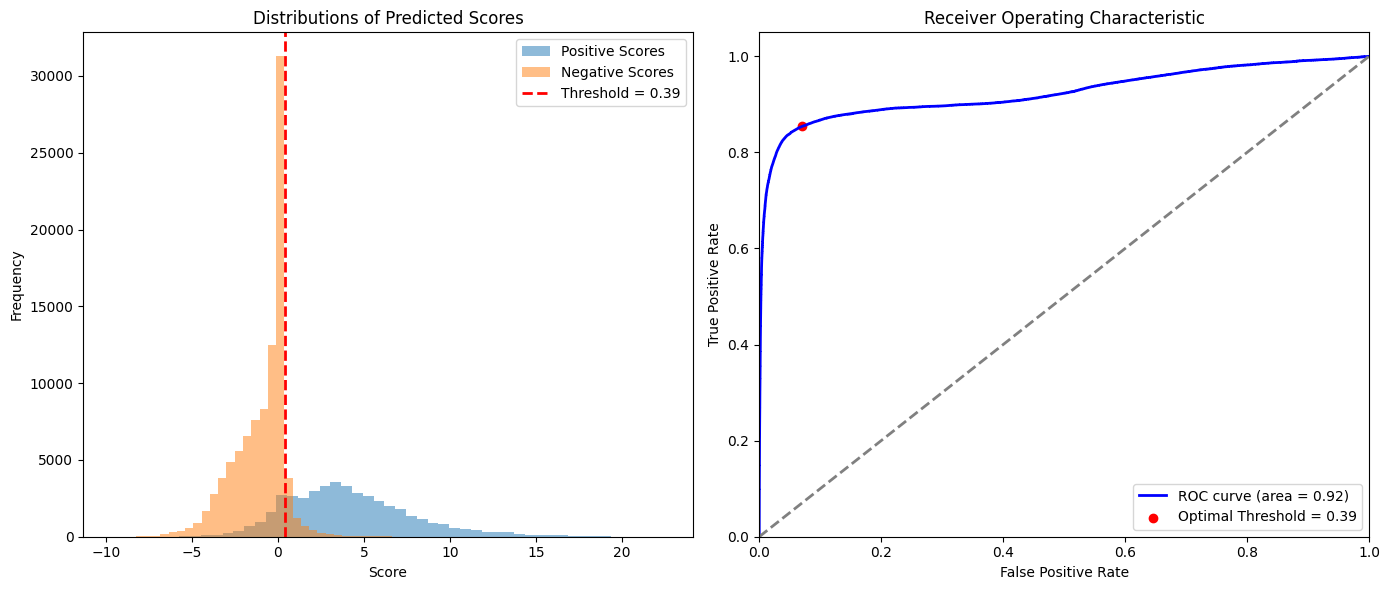

AUC: 0.9239518494083566


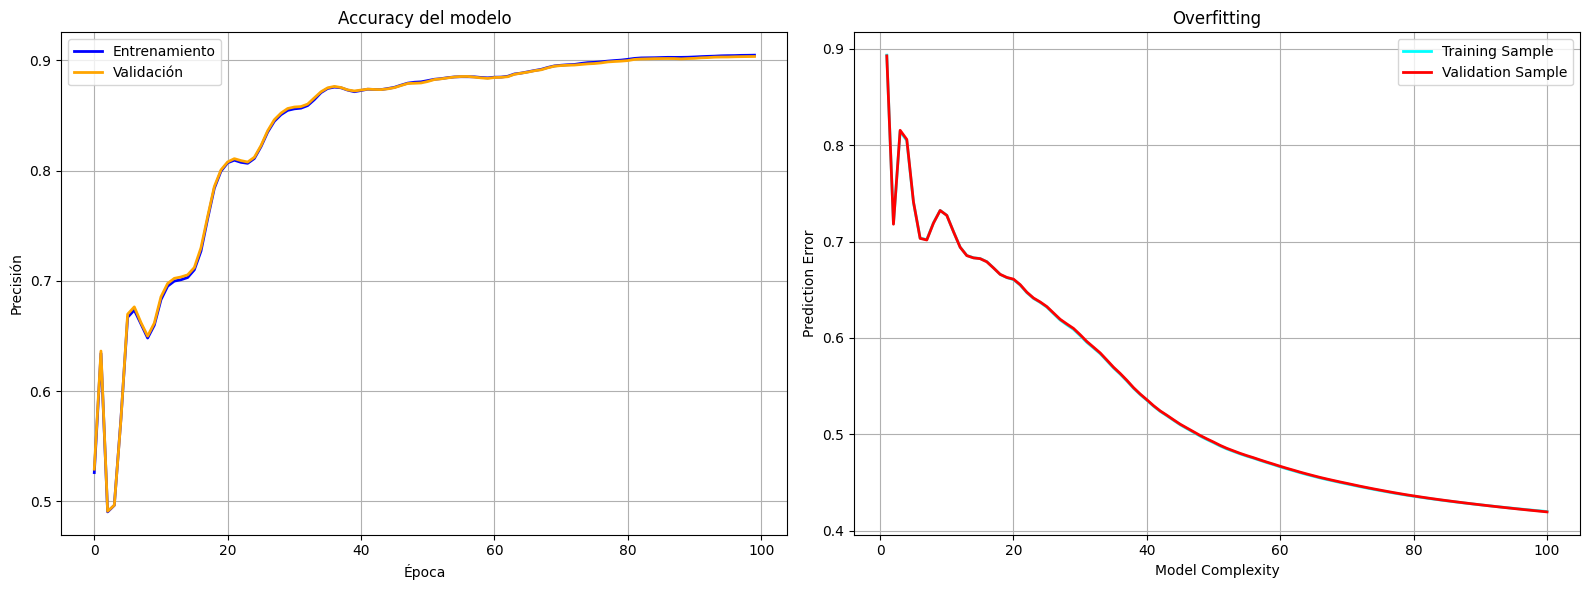

In [11]:
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset(0.4)
# gnn.split_dtaset_v2()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1
labels = gnn.dgl_graph.edata["Relationship"].float()
num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 15
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, num_feat_out)
pred = DotPredictor()

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.007)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())
  
  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())


  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)




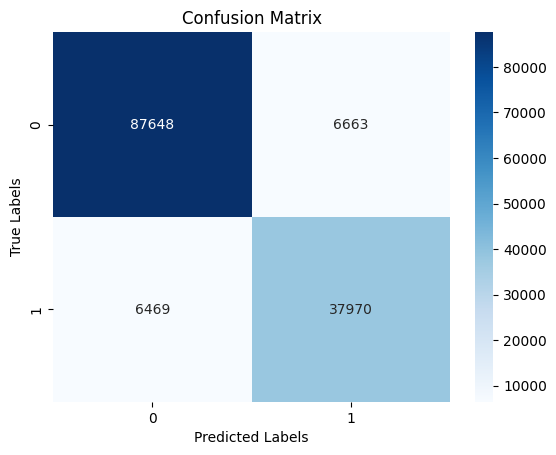

Classification Report:

              precision    recall  f1-score   support

           0     0.9313    0.9294    0.9303     94311
           1     0.8507    0.8544    0.8526     44439

    accuracy                         0.9054    138750
   macro avg     0.8910    0.8919    0.8914    138750
weighted avg     0.9055    0.9054    0.9054    138750



In [12]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)

# Caso 2: 
    * Model :GraphSAGE
    * Features : ALL
    * Predictor : MLPPredictor
    

In [20]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
# Path de donde se guardaran archivos
path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "/home/vale/Desktop/GIT/TESIS/datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename)

# 3.- Eliminar nodos de grado 1 hojas

# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges


Done saving data into cached files.
Graph(num_nodes=74145, num_edges=461889,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Training edges: 277472
Validation edges: 92357
Test edges: 92060
In epoch 0, train loss: 0.6539396643638611, val loss: 0.6552042961120605
In epoch 10, train loss: 0.5141865611076355, val loss: 0.5159475803375244
In epoch 20, train loss: 0.34430330991744995, val loss: 0.3468411862850189
In epoch 30, train loss: 0.20385515689849854, val loss: 0.20620006322860718
In epoch 40, train loss: 0.16835717856884003, val loss: 0.17051738500595093
In epoch 50, train loss: 0.15271462500095367, val loss: 0.15508587658405304
In epoch 60, train loss: 0.14107836782932281, val loss: 0.14300139248371124
In epoch 70, train loss: 0.1326446384191513, val loss: 0.13465796411037445
In epoch 80, train loss: 0.12662266194820404, val loss: 0.12863850593566895
In epoch 90, train loss: 0.12163668

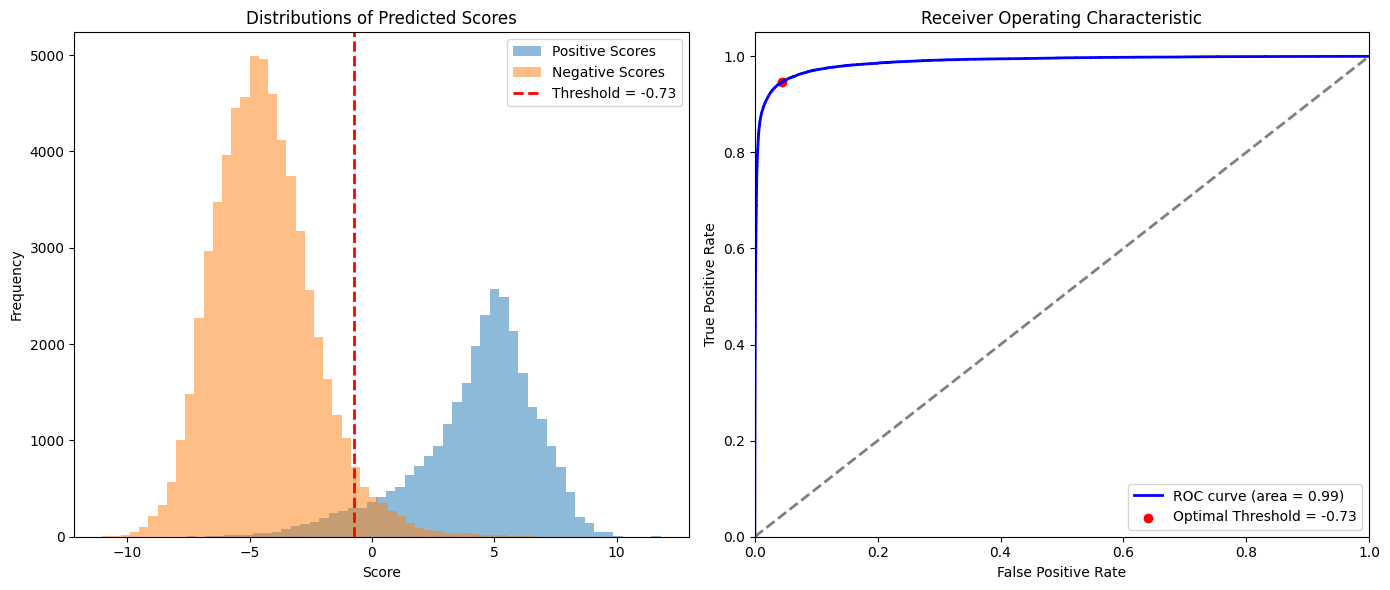

AUC: 0.9880127064674895


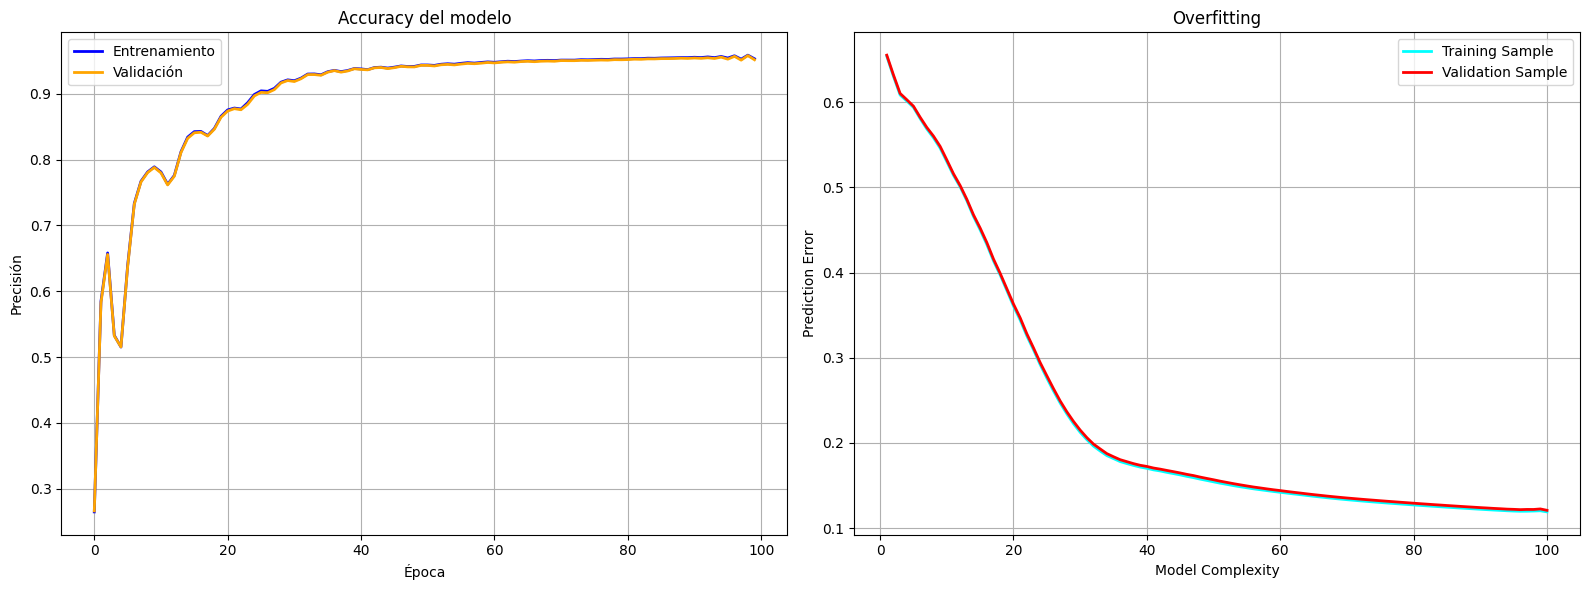

In [25]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 16
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, 8)
pred = MLPPredictor(8,1)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.006)

# ----------- 4. training -------------------------------- #
# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []
for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())


  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())

  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  

  # backward
  optimizer.zero_grad()
  # train_loss.backward()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)


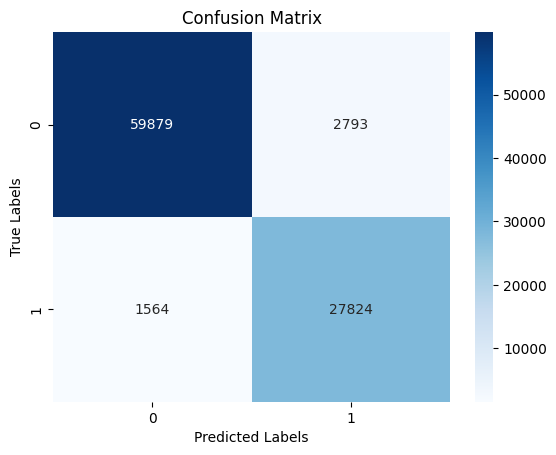

Classification Report:

              precision    recall  f1-score   support

           0     0.9745    0.9554    0.9649     62672
           1     0.9088    0.9468    0.9274     29388

    accuracy                         0.9527     92060
   macro avg     0.9417    0.9511    0.9461     92060
weighted avg     0.9536    0.9527    0.9529     92060



In [26]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)

# Caso 3: 
    * Model :GraphSAGE
    * Features : in_degree y out_degree
    * Predictor : DotPredictor
    

In [9]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
""" node_id,feat
 1,"10, 7"
 7843,"33, 54"

 """

path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraphDegree/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.only_degree_features_nodes(features_filename)


graph.add_as_rank_api_attributes()
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges
[SAVE IN: /home/vale/Desktop/GIT/TESIS/datasets/DGL_Graph/MYCODEDiGraphDegree/nodes.csv]
[PATH] /home/vale/Desktop/GIT/TESIS/datasets/DGL_Graph/MYCODEDiGraphDegree/


Done saving data into cached files.
[DATASET] Graph(num_nodes=74145, num_edges=461889,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
[DATASET] tensor([[0.2626, 0.2277],
        [0.3036, 0.1518],
        [0.3385, 0.1203],
        ...,
        [0.1203, 0.0000],
        [0.1203, 0.2809],
        [0.0759, 0.0000]])
In epoch 0, train loss: 0.7340303063392639, val loss: 0.7337589859962463
In epoch 10, train loss: 0.5595546960830688, val loss: 0.5610631108283997
In epoch 20, train loss: 0.41880759596824646, val loss: 0.4192700982093811
In epoch 30, train loss: 0.23924949765205383, val loss: 0.23960182070732117
In epoch 40, train loss: 0.2037019580602646, val loss: 0.20426668226718903
In epoch 50, train loss: 0.19553019106388092, val loss: 0.1965281069278717
In epoch 60, train loss: 0.18720172345638275, val loss: 0.1880284696817398
In epoch 70, train loss: 0.18062397837638855, val loss: 0.1814766

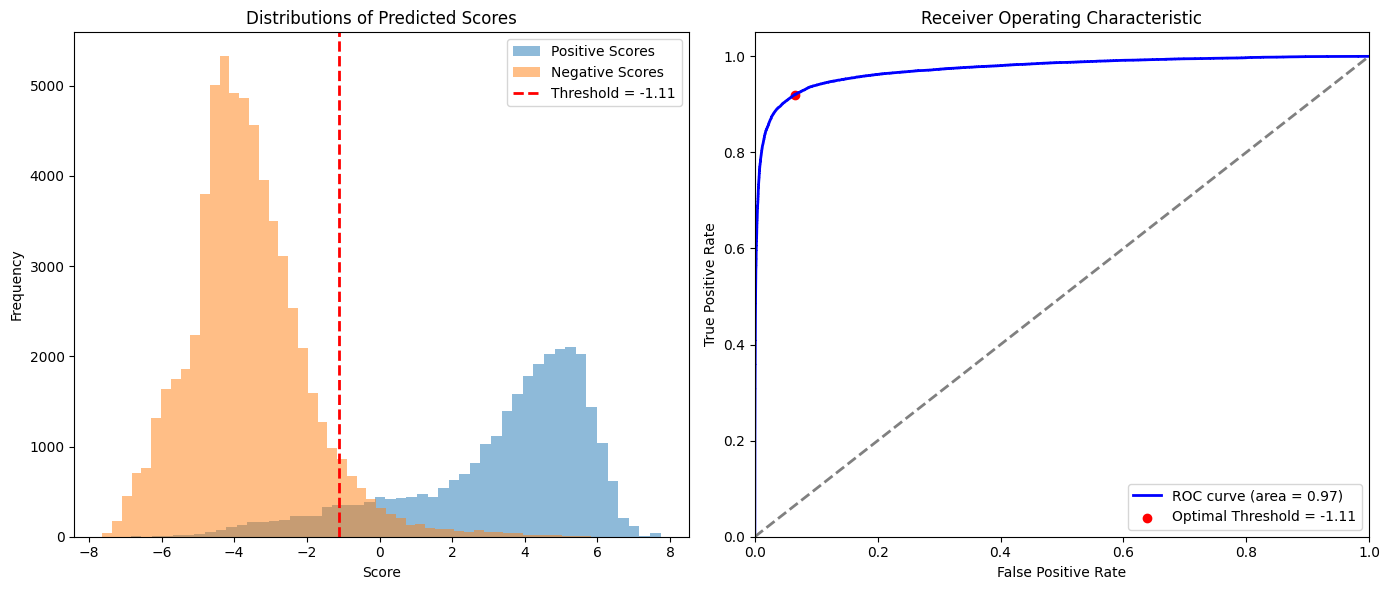

AUC: 0.9736283043563153


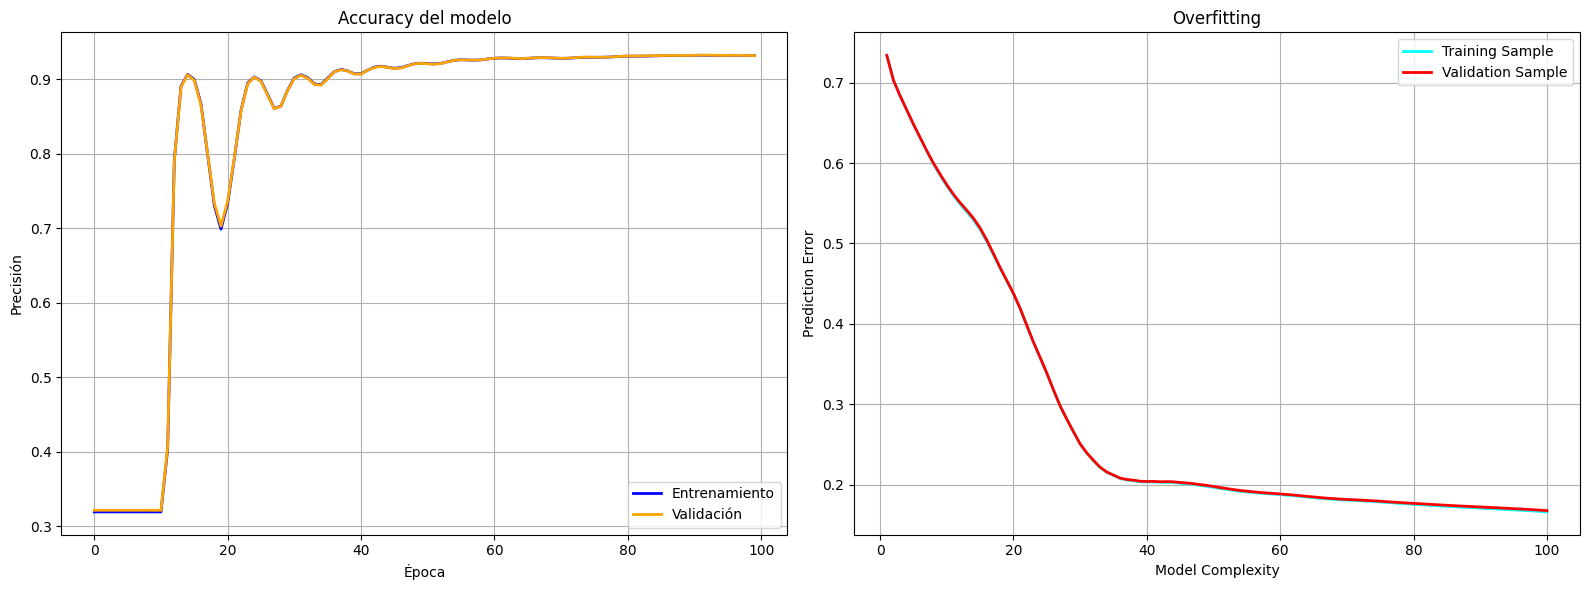

In [82]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraphDegree/"

gnn = GNN(debug=False)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset(0.6)

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() #FIXME:
# print(gnn.dgl_graph.ndata['feat'] )

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 15
num_feat_out = 1
# DATASET GRAPH ----------------------------------------------
print("[DATASET]",gnn.dgl_graph)
print("[DATASET]",gnn.dgl_graph.ndata['feat'])

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, 8)
pred = MLPPredictor(8,1)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())


  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())

  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #
plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)


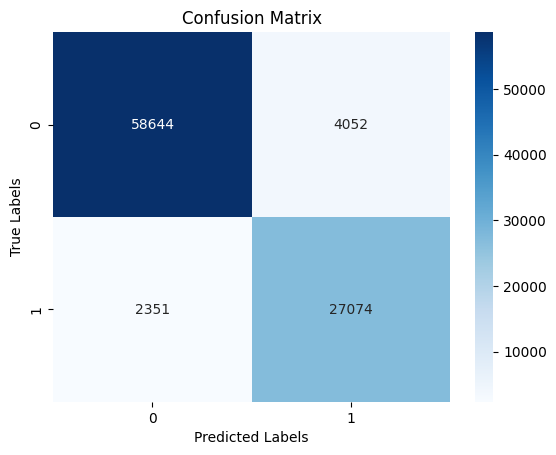

Classification Report:

              precision    recall  f1-score   support

           0     0.9615    0.9354    0.9482     62696
           1     0.8698    0.9201    0.8943     29425

    accuracy                         0.9305     92121
   macro avg     0.9156    0.9277    0.9212     92121
weighted avg     0.9322    0.9305    0.9310     92121



In [83]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)

# Caso 4: 
    * Model :GraphSAGE
    * Features : ['AS_rank_continent','peeringDB_info_ratio','peeringDB_info_scope','peeringDB_info_type','peeringDB_policy_general' 'ASDB_C1L1', 'AS_rank_numberAsns', 'AS_rank_customer', 'AS_rank_peer', 'peeringDB_ix_count', 'peeringDB_fac_count', 'cti_top']
    * Predictor : MLPPredictor

In [47]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------

LIST_FEATURES_NO_CATEG = [
                        # 'AS_rank_numberAsns', 
                        # 'AS_rank_customer', 
                        'peeringDB_fac_count', 
                        'cti_top']

LIST_FEATURES_CATEG = [
                        # 'AS_rank_continent',
                        #  'peeringDB_info_ratio',
                        # 'peeringDB_info_scope',
                        # 'peeringDB_info_type',
                        # 'peeringDB_policy_general'
                        # 'ASDB_C1L1'
                        ]

# Crear Di graph 
# list_feat = LIST_FEATURES_NO_CATEG + LIST_FEATURES_CATEG
list_feat =  LIST_FEATURES_NO_CATEG

path_dataset = os.getcwd() +  "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  # o "MultiDiGraph"
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename,list_feat)


# 3.- Eliminar nodos de grado 1 hojas

# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges


Done saving data into cached files.
[IN_FEATS] tensor([[0.0000, 0.0000],
        [0.0000, 0.0192],
        [0.1653, 0.0049],
        ...,
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000]])
[DGL Graph] Graph(num_nodes=74145, num_edges=461889,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
In epoch 0, train loss: 0.6820039749145508, val loss: 0.6820196509361267
In epoch 10, train loss: 0.644230842590332, val loss: 0.6444259285926819
In epoch 20, train loss: 0.5965187549591064, val loss: 0.596882164478302
In epoch 30, train loss: 0.52840656042099, val loss: 0.5290771126747131
In epoch 40, train loss: 0.44475504755973816, val loss: 0.44576334953308105
In epoch 50, train loss: 0.3790050745010376, val loss: 0.3808739185333252
In epoch 60, train loss: 0.3564373552799225, val loss: 0.35848671197891235
In epoch 70, train loss: 0.3400089740753174, val loss: 0.342186599969

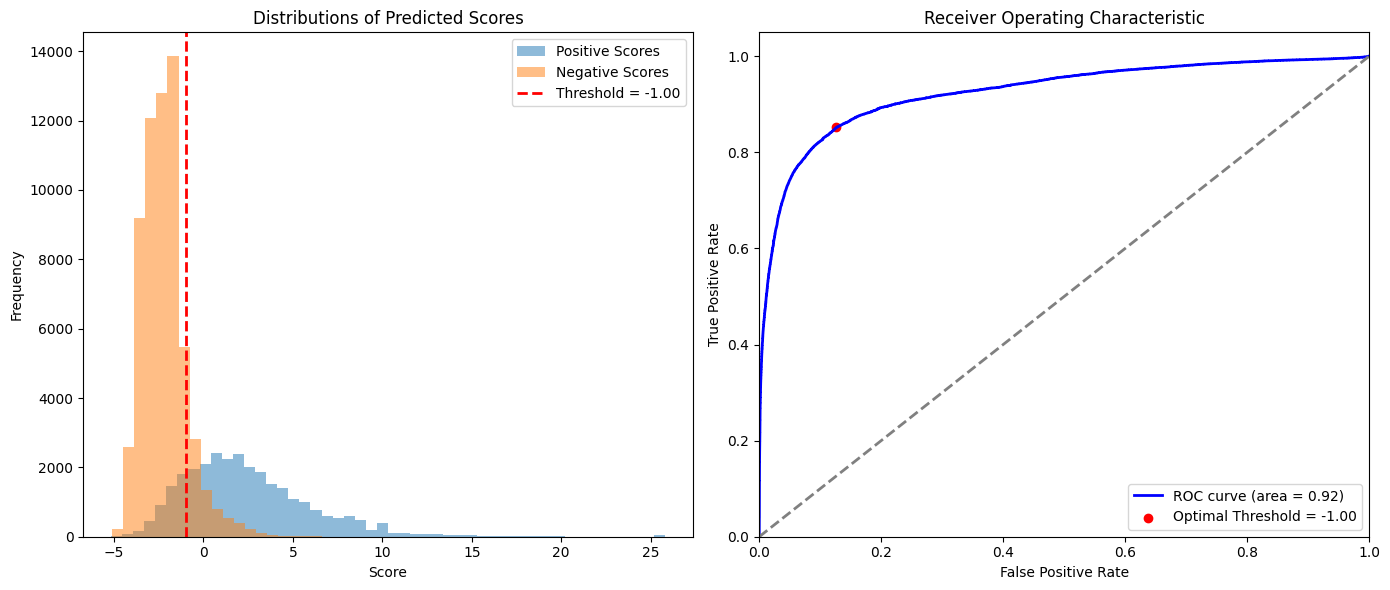

AUC: 0.9248093810245266


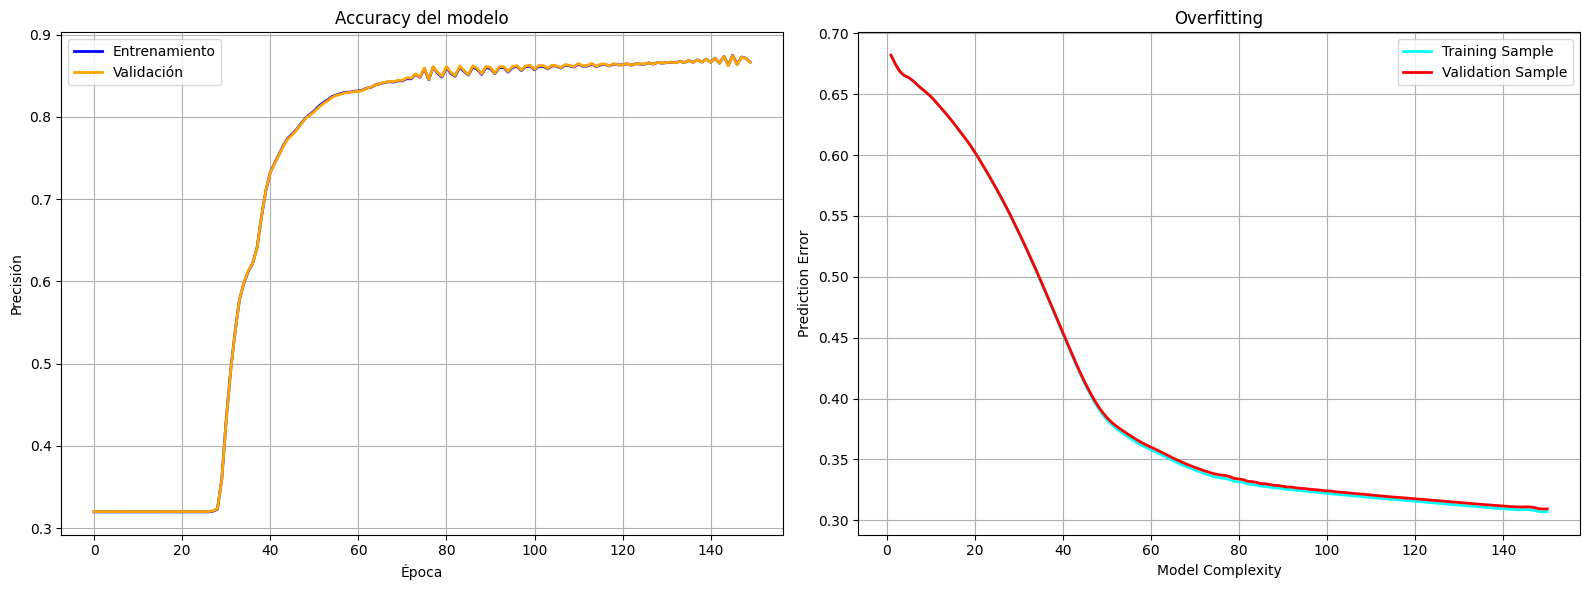

In [48]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=False)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset(0.6)

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"]
print("[IN_FEATS]",in_feats)
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 16
num_feat_out = 1

# DATASET GRAPH ----------------------------------------------
print("[DGL Graph]",gnn.dgl_graph)

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in , num_feat_hidden, 8)
pred = MLPPredictor(8,1)


# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.005)

# ----------- 4. training -------------------------------- #
# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for e in range(150):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())


  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())

  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)


  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)


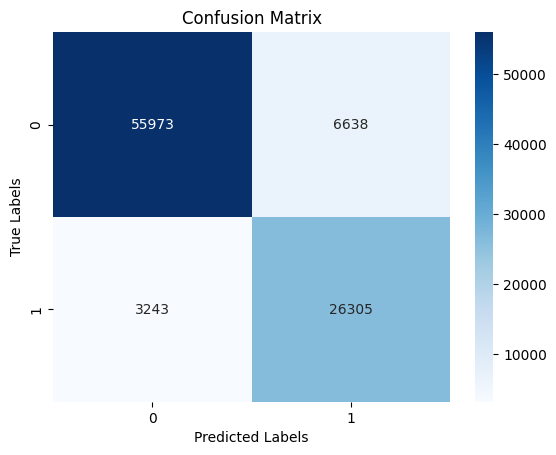

Classification Report:

              precision    recall  f1-score   support

           0     0.9452    0.8940    0.9189     62611
           1     0.7985    0.8902    0.8419     29548

    accuracy                         0.8928     92159
   macro avg     0.8719    0.8921    0.8804     92159
weighted avg     0.8982    0.8928    0.8942     92159



In [36]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)


# Caso 5:
    * Model : ???
    * Features : ???
    * Predictor : ???
Se crea un grafo a partir de un collector de RIPE NCC y ver si este generaliza para otro grafos

In [ ]:
features_filename 

In [8]:
# Creación archivos edges.csv y nodes.csv para cada archivo de rrc y caida ----------------------------
# para la creación de nuestro dataset
path_files_rrc = "datasets/ROUTE_COLLECTORS/Downloads/"
path_files_caida = "datasets/CAIDA_AS_Relationships/Serial_2/"
list_downloaded_rrc_files = os.listdir(path_files_rrc)
list_caida_As_relationship = os.listdir(path_files_caida)
print(list_downloaded_rrc_files)
# list_downloaded_rrc_files = ['graph-2021-06-rrc03-ribs-edges.csv']
# list_downloaded_rrc_files = [ 'graph-2021-06-rrc03-ribs-edges.csv','graph-2022-03-rrc03-ribs-edges.csv','graph-2022-04-rrc01-ribs-edges.csv']

for edgelist_files in list_downloaded_rrc_files:

    # Extraer rrc, fecha y obtener archivo caida p ara año y mes    
    rrc = edgelist_files.split("-")[3]
    date = edgelist_files.split("-")[1] +edgelist_files.split("-")[2]  #202206
    finename_caida_relationships = fnmatch.filter(list_caida_As_relationship, date+"*")
    filename_edges = "edges_"+rrc+".csv"  # Nombre archivo edges (ej_edges_rrc0.csv)
    filename_nodes = "nodes_"+rrc+".csv"  # Nombre archivo nodes (ej_nodes_rrc0.csv)

    edge_list_source_file_csv = path_files_rrc + edgelist_files
    labeled_caida_data_file = path_files_caida + finename_caida_relationships[0] #FIXME: Si pongo un ade la mismma fecha hay valores que no me encuentra (edges para etiquetar)
    # labeled_caida_data_file = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2" #FIXME:Aqui esta el error
    
    # Directorio DGL Graph
    directory = f"datasets/DGL_Graph/Graphs{rrc}/"

    # Crear el directorio si no existe
    if not os.path.exists(directory):
        os.makedirs(directory)

    graph = Graph(f"datasets/DGL_Graph/Graphs{rrc}/", debug=True)
    graph.label_edgelist(labeled_caida_data_file,edge_list_source_file_csv,type="DiGraph",filename_out=filename_edges)
    print("[TOPOLOGÍA]", graph.nx_graph)
    # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
    features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
    # graph.features_nodes(features_filename,list_feat="all",filename_out=filename_nodes)
    graph.only_degree_features_nodes(features_filename,list_feat="all",filename_out=filename_nodes)

    # 3.- Eliminar nodos de grado 1 hojas
    # graph.remove_nodes_degree(1,filename_out=filename_edges)
    # graph.remove_nodes_degree(1,filename_out=filename_edges)
    # graph.remove_nodes_degree(1,filename_out=filename_edges)
    print("-------------------------------")


['graph-2022-01-rrc15-ribs-edges.csv', 'graph-2021-01-rrc23-ribs-edges.csv', 'graph-2021-01-rrc01-ribs-edges.csv', 'graph-2020-01-rrc15-ribs-edges.csv', 'graph-2021-01-rrc15-ribs-edges.csv', 'graph-2022-01-rrc01-ribs-edges.csv', 'graph-2022-01-rrc23-ribs-edges.csv', 'graph-2020-01-rrc01-ribs-edges.csv']
[Tamaño df_edges: (470202, 3)]
[Tamaño df_edges_labeless: (204856, 2)]
Creando archivo edges.csv
[Tamaño Data Frame Merge]: (204856, 3)
[Grafo NX]: DiGraph with 78692 nodes and 204854 edges
[SAVE IN]: datasets/DGL_Graph/Graphsrrc15/edges_rrc15.csv
[TOPOLOGÍA] DiGraph with 78692 nodes and 204854 edges


TypeError: Graph.only_degree_features_nodes() got an unexpected keyword argument 'list_feat'

In [7]:
# Extraer rrc, fecha y obtener archivo caida p ara año y mes   
edgelist_files = 'graph-2022-01-rrc15-ribs-edges.csv'
rrc = edgelist_files.split("-")[3]
date = edgelist_files.split("-")[1] +edgelist_files.split("-")[2]  #202206
finename_caida_relationships = fnmatch.filter(list_caida_As_relationship, date+"*")
filename_edges = "edges_"+rrc+".csv"  # Nombre archivo edges (ej_edges_rrc0.csv)
filename_nodes = "nodes_"+rrc+".csv"  # Nombre archivo nodes (ej_nodes_rrc0.csv)

edge_list_source_file_csv = path_files_rrc + edgelist_files
labeled_caida_data_file = path_files_caida + finename_caida_relationships[0] #FIXME: Si pongo un ade la mismma fecha hay valores que no me encuentra (edges para etiquetar)
labeled_caida_data_file = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"

graph = Graph(f"datasets/DGL_Graph/GraphsRRC{rrc}/", debug=True)
graph.label_edgelist(labeled_caida_data_file,edge_list_source_file_csv,type="DiGraph")
print("[TOPOLOGÍA]", graph.nx_graph)
# 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename,list_feat="all",filename_out=filename_nodes)

# 3.- Eliminar nodos de grado 1 hojas
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

NameError: name 'list_caida_As_relationship' is not defined

In [6]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/Graphsrrc01"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=True)

print(gnn.dgl_graph)

gnn.split_dataset(0.6)

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 16
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, 8)
pred = MLPPredictor(8,1)


# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.05)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())
  
  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())


  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)




Done saving data into cached files.
Graph(num_nodes=67786, num_edges=158967,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.float32)})
Graph(num_nodes=67786, num_edges=158967,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.float32)})
Training edges: 95583
Validation edges: 31899
Test edges: 31485
In epoch 0, train loss: nan, val loss: nan
In epoch 10, train loss: nan, val loss: nan
In epoch 20, train loss: nan, val loss: nan
In epoch 30, train loss: nan, val loss: nan
In epoch 40, train loss: nan, val loss: nan
In epoch 50, train loss: nan, val loss: nan
In epoch 60, train loss: nan, val loss: nan
In epoch 70, train loss: nan, val loss: nan
In epoch 80, train loss: nan, val loss: nan
In epoch 90, train loss: nan, val loss: nan


/home/vale/.local/lib/python3.10/site-packages/sklearn/utils/_array_api.py:390: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_true contains NaN.

In [ ]:
# TODO: Importar segundo dataset para el test

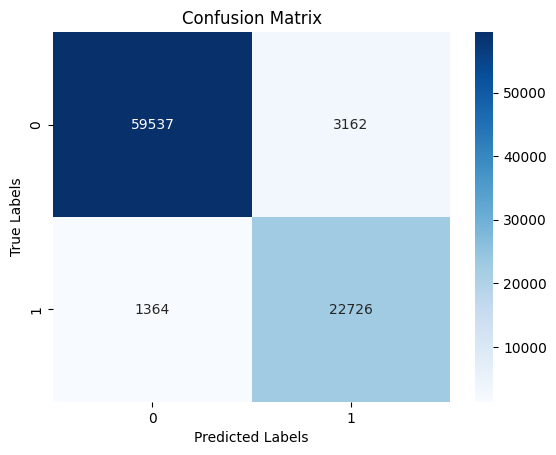

Classification Report:

              precision    recall  f1-score   support

           0     0.9776    0.9496    0.9634     62699
           1     0.8779    0.9434    0.9094     24090

    accuracy                         0.9479     86789
   macro avg     0.9277    0.9465    0.9364     86789
weighted avg     0.9499    0.9479    0.9484     86789



In [55]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)

# Caso 6:
    * Model : ???
    * Features : ???
    * Predictor : ???
Agrefo mis atributos sacados de APIs

In [ ]:
TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}

In [3]:
date = "2020-01-01"
graph_api = Graph_API(path="datasets/DGL_Graph/Graphsrrc01/", date=date,debug=True)
edge_list_source_file_csv = "datasets/ROUTE_COLLECTORS/Downloads/graph-2020-01-rrc01-ribs-edges.csv"
# 1.- Creo topologia dataset y label 
type = "DiGraph"  # o "MultiDiGraph"
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
# graph_api.label_edgelist(edge_list_source_file_csv, type="DiGraph", filename_out="edges_rrc01.csv") #Se de mora demaiado tiempo

graph_api.read_from_relationship_edgelist(file_path,type,out_file="edges_rrc01.csv")
print("[TOPOLOGÍA]", graph_api.nx_graph)

# asn = "14117"  # Reemplaza este valor con el ASN que desees consultar
result = graph_api.features_nodes(filename_out="nodes_rrc01.csv")
# Filtrar edges con nodos 
graph_api.filter_edges_with_attributes(nodes_file="nodes_rrc01.csv", edges_file="edges_rrc01.csv", output_file="edges_rrc01.csv")

# graph_api.normalize_features("nodes_rrc01.csv","nodes_rrc01.csv")

# print(result)  # Imprimir el JSON retornado

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges
Creating nodes.csv file
[PATH] datasets/DGL_Graph/Graphsrrc01/nodes_rrc01.csv
Node 500 of 74145 processed
Node 1000 of 74145 processed
Node 1500 of 74145 processed
Node 2000 of 74145 processed
Node 2500 of 74145 processed
Node 3000 of 74145 processed
Node 3500 of 74145 processed
Node 4000 of 74145 processed
Node 4500 of 74145 processed
Node 5000 of 74145 processed
Node 5500 of 74145 processed
Node 6000 of 74145 processed
Node 6500 of 74145 processed
Node 7000 of 74145 processed
Node 7500 of 74145 processed
Node 8000 of 74145 processed
Node 8500 of 74145 processed
Node 9000 of 74145 processed
Node 9500 of 74145 processed
Node 10000 of 74145 processed
Node 10500 of 74145 processed
Node 11000 of 74145 processed
Node 11500 of 74145 processed
Node 12000 of 74145 processed
Node 12500 of 74145 processed
Node 13000 of 74145 processed
Node 13500 of 74145 processed
Node 14000 of 74145 processed
Node 14500 of 74145 processed
Node 15000 of 7414

TypeError: 'NoneType' object is not subscriptable

# Caso 7:
    * Model : GraphSAGE 
    * Features : ???
    * Predictor : MLP

SAMPLING-> Neighbour node sampling
BATCH NORMALIZATION ->
DROPOUT ->



In [2]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
# Path de donde se guardaran archivos
path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "/home/vale/Desktop/GIT/TESIS/datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename)

# 3.- Eliminar nodos de grado 1 hojas

# NO PERMITE TENER NODOS CON GRADO 0
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges


In [30]:
# Grafo
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"
# data_path = "datasets/DGL_Graph/MYCODEDiGraphDegree/"
gnn = GNN(debug=False)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset(0.2)
gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() #FIXME:
node_features = gnn.dgl_graph.ndata['feat']
labels = gnn.dgl_graph.edata["Relationship"].float()

# gnn.split_dtaset_v2()
train_mask = gnn.train_mask
test_mask = gnn.test_mask

# Obtener índices de nodos de entrenamiento
train_nids = train_mask.nonzero(as_tuple=True)[0]

# Obtener índices de nodos de prueba
test_nids = test_mask.nonzero(as_tuple=True)[0]

print(f"TRAIN IDX: {train_mask}")
print(f"TEST IDX: {test_mask}")

print(f"TRAIN NIDS: {train_nids}")
print(f"TEST NIDS: {test_nids}")

Done saving data into cached files.
TRAIN IDX: tensor([False, False, False,  ...,  True, False, False])
TEST IDX: tensor([ True, False,  True,  ..., False, False, False])
TRAIN NIDS: tensor([    11,     19,     22,  ..., 461884, 461885, 461886])
TEST NIDS: tensor([     0,      2,      5,  ..., 461877, 461879, 461881])


In [36]:
# Definir Dataloader y Sampler Training
sampler_train = dgl.dataloading.NeighborSampler([1, 1])


# Transformar el sampler para predicción de aristas
sampler_train = dgl.dataloading.as_edge_prediction_sampler(
    sampler_train, 
    # exclude='reverse_id',  # Excluir aristas inversas
    # reverse_eids=reverse_eids,  # Especificar las aristas inversas
    # negative_sampler=dgl.dataloading.negative_sampler.Uniform(5)  # Sampler negativo con 5 muestras negativas
)

train_dataloader = dgl.dataloading.DataLoader(
    # The following arguments are specific to DGL's DataLoader.
    gnn.dgl_graph,              # The graph
    train_nids,         # The node IDs to iterate over in minibatches
    sampler_train,            # The neighbor sampler
    # The following arguments are inherited from PyTorch DataLoader.
    batch_size=1000,    # Batch size
    shuffle=True,       # Whether to shuffle the nodes for every epoch
    drop_last=False,    # Whether to drop the last incomplete batch
    # num_workers=0       # Number of sampler processes
)



# Definir Dataloader y Sampler Evaluación ------------------------------------------------------------------
sampler_test = dgl.dataloading.NeighborSampler([4,4])


# Transformar el sampler para predicción de aristas
sampler_test = dgl.dataloading.as_edge_prediction_sampler(
    sampler_test, 
    # exclude='reverse_id',  # Excluir aristas inversas
    # reverse_eids=reverse_eids,  # Especificar las aristas inversas
    # negative_sampler=dgl.dataloading.negative_sampler.Uniform(5)  # Sampler negativo con 5 muestras negativas
)

test_dataloader = dgl.dataloading.DataLoader(
    # The following arguments are specific to DGL's DataLoader.
    gnn.dgl_graph,              # The graph
    test_nids,         # The node IDs to iterate over in minibatches
    sampler_test,            # The neighbor sampler
    # The following arguments are inherited from PyTorch DataLoader.
    batch_size=1000,    # Batch size
    shuffle=True,       # Whether to shuffle the nodes for every epoch
    drop_last=False,    # Whether to drop the last incomplete batch
    # num_workers=0       # Number of sampler processes
)



  0%|          | 0/93 [00:00<?, ?it/s]/home/vale/.local/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
100%|██████████| 185/185 [00:00<00:00, 296.51it/s]


In epoch 0, train loss: 0.17127323150634766,


100%|██████████| 185/185 [00:00<00:00, 276.56it/s]


In epoch 1, train loss: 0.1492457538843155,


100%|██████████| 185/185 [00:00<00:00, 279.55it/s]


In epoch 2, train loss: 0.1253148466348648,


100%|██████████| 185/185 [00:00<00:00, 289.72it/s]


In epoch 3, train loss: 0.10676252841949463,


100%|██████████| 185/185 [00:00<00:00, 280.34it/s]


In epoch 4, train loss: 0.13012312352657318,


100%|██████████| 185/185 [00:00<00:00, 274.10it/s]


In epoch 5, train loss: 0.11145832389593124,


100%|██████████| 185/185 [00:00<00:00, 272.99it/s]


In epoch 6, train loss: 0.1116960346698761,


100%|██████████| 185/185 [00:00<00:00, 290.32it/s]


In epoch 7, train loss: 0.10099237412214279,


100%|██████████| 185/185 [00:00<00:00, 291.15it/s]


In epoch 8, train loss: 0.08477743715047836,


100%|██████████| 185/185 [00:00<00:00, 289.16it/s]


In epoch 9, train loss: 0.061967942863702774,


100%|██████████| 185/185 [00:00<00:00, 296.69it/s]


In epoch 10, train loss: 0.23760545253753662,


100%|██████████| 185/185 [00:00<00:00, 290.08it/s]


In epoch 11, train loss: 0.12931735813617706,


100%|██████████| 185/185 [00:00<00:00, 307.51it/s]


In epoch 12, train loss: 0.13341571390628815,


100%|██████████| 185/185 [00:00<00:00, 294.34it/s]


In epoch 13, train loss: 0.09731373935937881,


100%|██████████| 185/185 [00:00<00:00, 301.39it/s]


In epoch 14, train loss: 0.08062497526407242,


100%|██████████| 185/185 [00:00<00:00, 289.42it/s]


In epoch 15, train loss: 0.09725037217140198,


100%|██████████| 185/185 [00:00<00:00, 307.05it/s]


In epoch 16, train loss: 0.08940380066633224,


100%|██████████| 185/185 [00:00<00:00, 294.16it/s]


In epoch 17, train loss: 0.09925001114606857,


100%|██████████| 185/185 [00:00<00:00, 287.01it/s]


In epoch 18, train loss: 0.10301797837018967,


100%|██████████| 185/185 [00:00<00:00, 307.22it/s]


In epoch 19, train loss: 0.12109825760126114,


100%|██████████| 185/185 [00:00<00:00, 290.75it/s]


In epoch 20, train loss: 0.06387165933847427,


100%|██████████| 185/185 [00:00<00:00, 307.65it/s]


In epoch 21, train loss: 0.1067829504609108,


100%|██████████| 185/185 [00:00<00:00, 310.24it/s]


In epoch 22, train loss: 0.06833111494779587,


100%|██████████| 185/185 [00:00<00:00, 305.40it/s]


In epoch 23, train loss: 0.093414805829525,


100%|██████████| 185/185 [00:00<00:00, 297.00it/s]


In epoch 24, train loss: 0.09094971418380737,


100%|██████████| 185/185 [00:00<00:00, 293.74it/s]


In epoch 25, train loss: 0.07795938849449158,


100%|██████████| 185/185 [00:00<00:00, 300.62it/s]


In epoch 26, train loss: 0.1548275351524353,


100%|██████████| 185/185 [00:00<00:00, 302.44it/s]


In epoch 27, train loss: 0.14566104114055634,


100%|██████████| 185/185 [00:00<00:00, 306.25it/s]


In epoch 28, train loss: 0.08319444954395294,


100%|██████████| 185/185 [00:00<00:00, 304.35it/s]


In epoch 29, train loss: 0.07551751285791397,


100%|██████████| 185/185 [00:00<00:00, 284.94it/s]


In epoch 30, train loss: 0.09226864576339722,


100%|██████████| 185/185 [00:00<00:00, 306.05it/s]


In epoch 31, train loss: 0.09184687584638596,


100%|██████████| 185/185 [00:00<00:00, 308.32it/s]


In epoch 32, train loss: 0.14763757586479187,


100%|██████████| 185/185 [00:00<00:00, 294.28it/s]


In epoch 33, train loss: 0.11213283985853195,


100%|██████████| 185/185 [00:00<00:00, 302.69it/s]


In epoch 34, train loss: 0.08541195839643478,


100%|██████████| 185/185 [00:00<00:00, 306.63it/s]


In epoch 35, train loss: 0.11684729903936386,


100%|██████████| 185/185 [00:00<00:00, 298.24it/s]


In epoch 36, train loss: 0.08937571197748184,


100%|██████████| 185/185 [00:00<00:00, 282.28it/s]


In epoch 37, train loss: 0.16568408906459808,


100%|██████████| 185/185 [00:00<00:00, 312.21it/s]


In epoch 38, train loss: 0.04642808064818382,


100%|██████████| 185/185 [00:00<00:00, 267.73it/s]


In epoch 39, train loss: 0.1287972331047058,


100%|██████████| 185/185 [00:00<00:00, 276.78it/s]


In epoch 40, train loss: 0.11673863977193832,


100%|██████████| 185/185 [00:00<00:00, 265.98it/s]


In epoch 41, train loss: 0.08646253496408463,


100%|██████████| 185/185 [00:00<00:00, 277.60it/s]


In epoch 42, train loss: 0.08617541193962097,


100%|██████████| 185/185 [00:00<00:00, 282.30it/s]


In epoch 43, train loss: 0.12828296422958374,


100%|██████████| 185/185 [00:00<00:00, 252.07it/s]


In epoch 44, train loss: 0.12838999927043915,


100%|██████████| 185/185 [00:00<00:00, 255.46it/s]


In epoch 45, train loss: 0.08894912153482437,


100%|██████████| 185/185 [00:00<00:00, 252.16it/s]


In epoch 46, train loss: 0.07574193179607391,


100%|██████████| 185/185 [00:00<00:00, 257.41it/s]


In epoch 47, train loss: 0.12628819048404694,


100%|██████████| 185/185 [00:00<00:00, 258.42it/s]


In epoch 48, train loss: 0.16428594291210175,


100%|██████████| 185/185 [00:00<00:00, 262.74it/s]


In epoch 49, train loss: 0.08569533377885818,


100%|██████████| 185/185 [00:00<00:00, 256.91it/s]


In epoch 50, train loss: 0.08211714774370193,


100%|██████████| 185/185 [00:00<00:00, 249.16it/s]


In epoch 51, train loss: 0.05766594037413597,


100%|██████████| 185/185 [00:00<00:00, 260.83it/s]


In epoch 52, train loss: 0.12307422608137131,


100%|██████████| 185/185 [00:00<00:00, 265.53it/s]


In epoch 53, train loss: 0.0855628028512001,


100%|██████████| 185/185 [00:00<00:00, 261.83it/s]


In epoch 54, train loss: 0.12564176321029663,


100%|██████████| 185/185 [00:00<00:00, 265.32it/s]


In epoch 55, train loss: 0.08134771138429642,


100%|██████████| 185/185 [00:00<00:00, 264.63it/s]


In epoch 56, train loss: 0.1050880178809166,


100%|██████████| 185/185 [00:00<00:00, 258.83it/s]


In epoch 57, train loss: 0.11029239743947983,


100%|██████████| 185/185 [00:00<00:00, 266.00it/s]


In epoch 58, train loss: 0.1353405863046646,


100%|██████████| 185/185 [00:00<00:00, 264.15it/s]


In epoch 59, train loss: 0.10235825926065445,


100%|██████████| 185/185 [00:00<00:00, 266.71it/s]


In epoch 60, train loss: 0.09956385940313339,


100%|██████████| 185/185 [00:00<00:00, 252.04it/s]


In epoch 61, train loss: 0.08642533421516418,


100%|██████████| 185/185 [00:00<00:00, 256.72it/s]


In epoch 62, train loss: 0.12313409894704819,


100%|██████████| 185/185 [00:00<00:00, 248.96it/s]


In epoch 63, train loss: 0.1880326271057129,


100%|██████████| 185/185 [00:00<00:00, 268.74it/s]


In epoch 64, train loss: 0.06628678739070892,


100%|██████████| 185/185 [00:00<00:00, 265.01it/s]


In epoch 65, train loss: 0.11110222339630127,


100%|██████████| 185/185 [00:00<00:00, 266.70it/s]


In epoch 66, train loss: 0.07302076369524002,


100%|██████████| 185/185 [00:00<00:00, 267.50it/s]


In epoch 67, train loss: 0.18321199715137482,


100%|██████████| 185/185 [00:00<00:00, 263.46it/s]


In epoch 68, train loss: 0.046233683824539185,


100%|██████████| 185/185 [00:00<00:00, 256.39it/s]


In epoch 69, train loss: 0.13028286397457123,


100%|██████████| 185/185 [00:00<00:00, 266.64it/s]


In epoch 70, train loss: 0.1806560754776001,


100%|██████████| 185/185 [00:00<00:00, 257.28it/s]


In epoch 71, train loss: 0.08814665675163269,


100%|██████████| 185/185 [00:00<00:00, 256.79it/s]


In epoch 72, train loss: 0.1308746486902237,


100%|██████████| 185/185 [00:00<00:00, 259.47it/s]


In epoch 73, train loss: 0.10141380876302719,


100%|██████████| 185/185 [00:00<00:00, 248.60it/s]


In epoch 74, train loss: 0.08209960907697678,


100%|██████████| 185/185 [00:00<00:00, 235.24it/s]


In epoch 75, train loss: 0.09605877846479416,


100%|██████████| 185/185 [00:00<00:00, 267.92it/s]


In epoch 76, train loss: 0.10424944013357162,


100%|██████████| 185/185 [00:00<00:00, 264.53it/s]


In epoch 77, train loss: 0.0843246579170227,


100%|██████████| 185/185 [00:00<00:00, 269.18it/s]


In epoch 78, train loss: 0.09989011287689209,


100%|██████████| 185/185 [00:00<00:00, 267.63it/s]


In epoch 79, train loss: 0.13554173707962036,


100%|██████████| 185/185 [00:00<00:00, 269.95it/s]


In epoch 80, train loss: 0.1214420273900032,


100%|██████████| 185/185 [00:00<00:00, 260.92it/s]


In epoch 81, train loss: 0.023498758673667908,


100%|██████████| 185/185 [00:00<00:00, 270.49it/s]


In epoch 82, train loss: 0.12228810787200928,


100%|██████████| 185/185 [00:00<00:00, 269.28it/s]


In epoch 83, train loss: 0.11013849824666977,


100%|██████████| 185/185 [00:00<00:00, 257.22it/s]


In epoch 84, train loss: 0.11351361870765686,


100%|██████████| 185/185 [00:00<00:00, 263.90it/s]


In epoch 85, train loss: 0.08328474313020706,


100%|██████████| 185/185 [00:00<00:00, 258.54it/s]


In epoch 86, train loss: 0.09377766400575638,


100%|██████████| 185/185 [00:00<00:00, 261.68it/s]


In epoch 87, train loss: 0.07880423218011856,


100%|██████████| 185/185 [00:00<00:00, 265.07it/s]


In epoch 88, train loss: 0.12402832508087158,


100%|██████████| 185/185 [00:00<00:00, 270.86it/s]


In epoch 89, train loss: 0.09353962540626526,


100%|██████████| 185/185 [00:00<00:00, 252.61it/s]


In epoch 90, train loss: 0.1091395914554596,


100%|██████████| 185/185 [00:00<00:00, 269.39it/s]


In epoch 91, train loss: 0.07283785194158554,


100%|██████████| 185/185 [00:00<00:00, 258.92it/s]


In epoch 92, train loss: 0.09208259731531143,


100%|██████████| 185/185 [00:00<00:00, 270.29it/s]


In epoch 93, train loss: 0.08044979721307755,


100%|██████████| 185/185 [00:00<00:00, 266.10it/s]


In epoch 94, train loss: 0.11384689062833786,


100%|██████████| 185/185 [00:00<00:00, 271.34it/s]


In epoch 95, train loss: 0.07119172066450119,


100%|██████████| 185/185 [00:00<00:00, 209.14it/s]


In epoch 96, train loss: 0.11245793104171753,


100%|██████████| 185/185 [00:00<00:00, 263.79it/s]


In epoch 97, train loss: 0.06049175560474396,


100%|██████████| 185/185 [00:00<00:00, 259.67it/s]


In epoch 98, train loss: 0.059969499707221985,


100%|██████████| 185/185 [00:00<00:00, 265.01it/s]


In epoch 99, train loss: 0.1930578500032425,


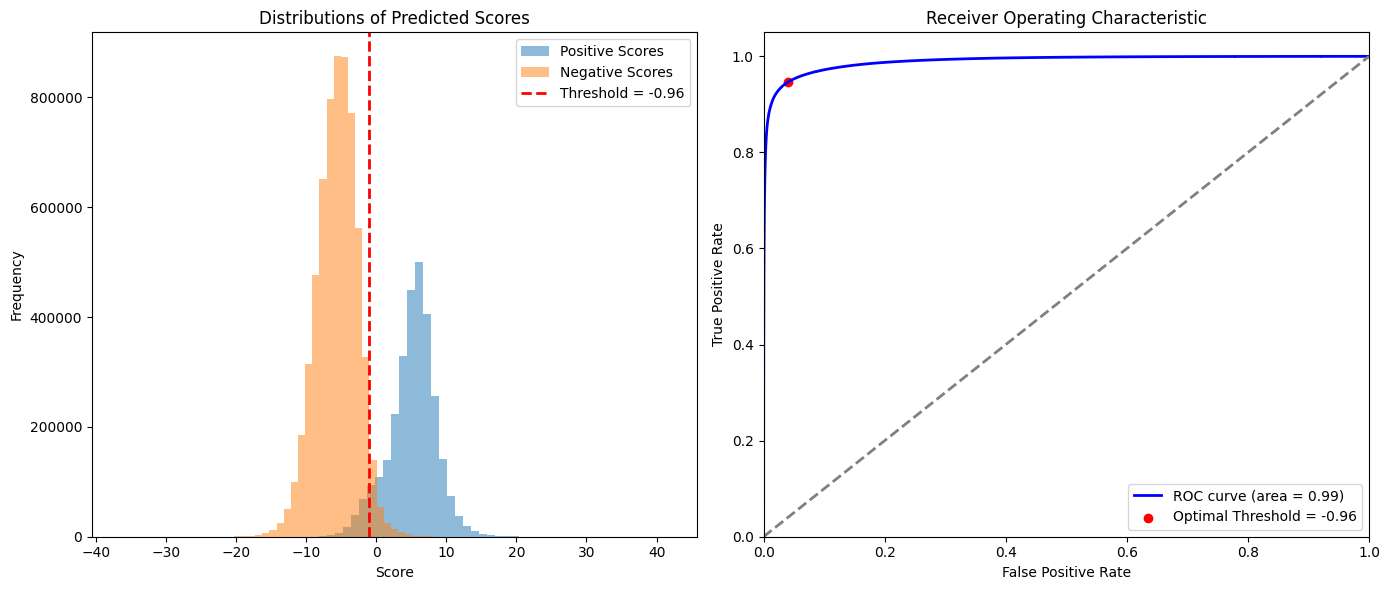

AUC: 0.9896096537130669
Optimal Threshold: -0.9637597799301147
Train Error [0.7266588807106018, 0.7058440446853638, 0.7042368650436401, 0.6436664462089539, 0.6372581124305725, 0.624772846698761, 0.5877317786216736, 0.5765068531036377, 0.5889105200767517, 0.5635119676589966, 0.5672763586044312, 0.5537146925926208, 0.5403743982315063, 0.5236219763755798, 0.4695533812046051, 0.48586612939834595, 0.44361376762390137, 0.4123436212539673, 0.43126180768013, 0.4229845702648163, 0.4177530109882355, 0.42315876483917236, 0.36901476979255676, 0.35974371433258057, 0.3308035135269165, 0.36054468154907227, 0.3267282247543335, 0.3255347013473511, 0.33944952487945557, 0.319078654050827, 0.31889858841896057, 0.2861403822898865, 0.2945800721645355, 0.29859593510627747, 0.28998133540153503, 0.30517998337745667, 0.28844159841537476, 0.248691588640213, 0.25098204612731934, 0.22892722487449646, 0.2170666754245758, 0.220412015914917, 0.22028331458568573, 0.1696965992450714, 0.19030843675136566, 0.236648976802

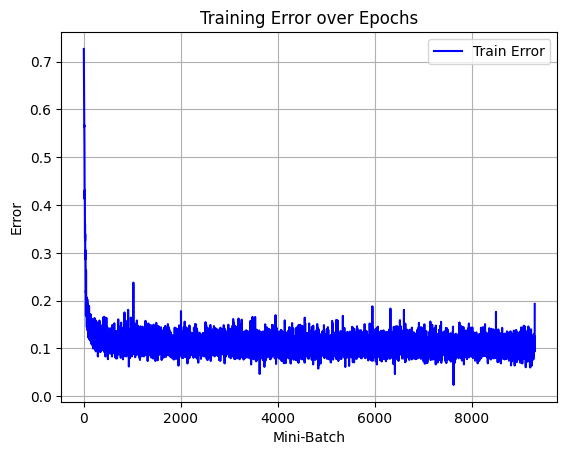

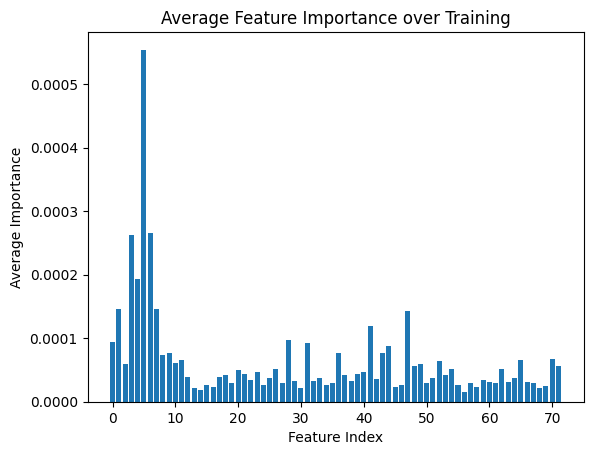

In [39]:

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
out_feats= 8


# # model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = ModelSAGESample(in_feats, h_feats, out_feats)
pred = MLPPredictor(8,1)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.05)

# ----------- 4. training -------------------------------- #
model_complexity = []

acc_val = []
acc_train = []

train_error = []
train_error_per_epoch = []
val_error = []
train_edges_id = []

# Inicializar listas para guardar logits y labels
all_logits = []
all_labels = []
# Almacenar la importancia de características por epoch
feature_importances = []
for epoch in range(100):
    model.train()
    val_loss_epoch=0
    num_batches = 0

    with tqdm.tqdm(train_dataloader) as tq:
        for step, (input_nodes, output_graph, mfgs) in enumerate(tq):
    
            mfgs = [graph for graph in mfgs]
            edge_ids = output_graph.edata[dgl.EID]
            inputs = mfgs[0].srcdata['feat']
            # Hacer que los inputs requieran gradiente
            inputs.requires_grad_(True)
            # Embeddings de nodos
            h = model(mfgs, inputs)
            logits =  pred(output_graph, h)
            
            
            train_edges_id.append(edge_ids)

            # Usar los IDs de los bordes para obtener las etiquetas reales
            labels_batch_output = gnn.dgl_graph.edata['Relationship'][edge_ids].float()

            all_logits.append(logits.detach().cpu().numpy())
            all_labels.append(labels_batch_output.cpu().numpy())
            # print("LOGITS",logits,logits.shape)
            # print("LABEL",mfgs[-1].edata['Relationship'].shape )

            # Calculo pérdida --------------------------------------------------------
            train_loss = F.binary_cross_entropy_with_logits(logits, labels_batch_output)
            train_error.append(train_loss.item())


            val_loss_epoch += train_loss.item()
            num_batches += 1
            
            # backward
            optimizer.zero_grad()
            # train_loss.backward()
            train_loss.backward()

                        # Capturar los gradientes con respecto a los inputs (características)
            grad = inputs.grad  # Este es el gradiente de la pérdida con respecto a los inputs
            feature_importance_batch = grad.abs().mean(dim=0).cpu().numpy()  # Promediar sobre los nodos y las dimensiones de características
            feature_importances.append(feature_importance_batch)
            optimizer.step()
    train_error_per_epoch.append(val_loss_epoch / num_batches)
        
    # Validación
    model.eval()
    val_loss_epoch = 0
    num_batches = 0
    with torch.no_grad():
        with tqdm.tqdm(test_dataloader) as tq:
            for step, (input_nodes, output_graph, mfgs) in enumerate(tq):
                mfgs = [graph for graph in mfgs]
                edge_ids = output_graph.edata[dgl.EID]
                inputs = mfgs[0].srcdata['feat']
                
                
                # Forward para validación
                h_val = model(mfgs, inputs)
                logits_val = pred(output_graph, h_val)
                # Obtener las etiquetas reales
                labels_batch_output_val = gnn.dgl_graph.edata['Relationship'][edge_ids].float()
                # Calcular pérdida de validación
                val_loss_batch = F.binary_cross_entropy_with_logits(logits_val, labels_batch_output_val)
                val_loss_epoch += val_loss_batch.item()
                num_batches += 1

    # Almacenar el promedio de la pérdida de validación por epoch
    val_error.append(val_loss_epoch / num_batches)




    if epoch % 1 == 0:
        print('In epoch {}, train loss: {},'.format( epoch,train_loss))

# Convertir la lista de importancias en un array para análisis
feature_importances = np.array(feature_importances)

# Calcular la importancia promedio a lo largo de todos los batches y epochs
avg_feature_importance = feature_importances.mean(axis=0)


# ----------- 5. Definir threashold -------------- 
# Concatenar todos los logits y etiquetas al final del entrenamiento
all_logits = np.concatenate(all_logits, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
optimal_threshold = plot_roc_curve(all_labels, all_logits)
print(f"Optimal Threshold: {optimal_threshold}")
          

# ----------- 6. plot the loss and accuracy de training-------------- #
# FIXME: Ess asi por meintras para q no s ecaiga la funcion
print("Train Error",train_error)
# acc_train = train_error
# val_error = train_error
# acc_val = train_error
# model_complexity = [i for i in range(len(train_error))]


# Crear gráfico del error de entrenamiento
plt.figure()  # Crear una nueva figura
plt.plot(train_error, label='Train Error', color='blue')  # Error de entrenamiento en azul
plt.xlabel('Mini-Batch')
plt.ylabel('Error')
plt.title('Training Error over Epochs')
plt.legend()
plt.grid(True)
plt.show()  # Mostrar el gráfico de error de entrenamiento


# ----------- 6. Visualización de la Importancia de Características -------------- #
plt.figure()
plt.bar(range(len(avg_feature_importance)), avg_feature_importance)
plt.xlabel('Feature Index')
plt.ylabel('Average Importance')
plt.title('Average Feature Importance over Training')
plt.show()


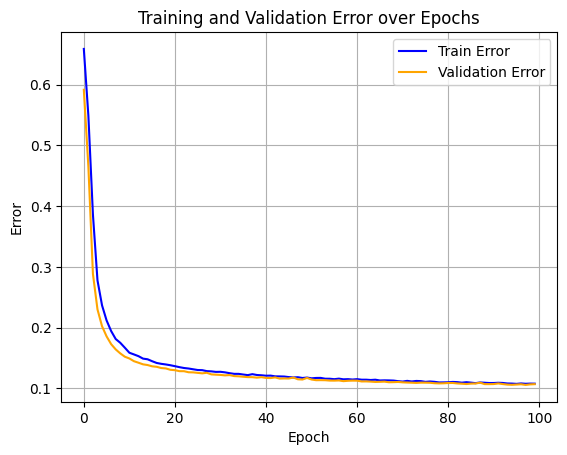

In [38]:
# Crear gráfico combinado de error de entrenamiento y validación
plt.figure()  # Crear una nueva figura
plt.plot(train_error_per_epoch, label='Train Error', color='blue')  # Error de entrenamiento en azul
plt.plot(val_error, label='Validation Error', color='orange')  # Error de validación en naranja
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Training and Validation Error over Epochs')
plt.legend()
plt.grid(True)
plt.show()  # Mostrar el gráfico combinado